<a href="https://colab.research.google.com/github/kokovariax/kokoRepo/blob/master/3d_symbolic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Symbolic Regression**

## 1. What is symbolic regression?

**Symbolic regression** is a _machine learning_ technique that finds a **symbolic expression** that matches data from an unknown function. In other words, it is a machinery able to identify an underlying mathematical expression that best describes a relationship between one or more variables.

The symbolic regression problem for mathematical functions has been tackled with a variety of methods, including:

- **Sparse regression**: [Quade, et, al.](https://aip.scitation.org/doi/abs/10.1063/1.5027470?ai=1gvoi&mi=3ricys&af=R&), [Brunton, et al.](https://arxiv.org/pdf/1509.03580.pdf);
- **Genetic algorithms**: [GPTIPS](https://sites.google.com/site/gptips4matlab/) (`Matlab`), [gplearn](https://gplearn.readthedocs.io/en/stable/) (`Python`);
- [AI Feynman](https://advances.sciencemag.org/content/6/16/eaay2631/tab-pdf) (Tegmark).

## 2. How does it works?

It builds a set of random formulas to represent the relationship between known independent variables and their dependent variable targets in order to predict them.

Each successive **step** (_generation_) of programs is then **transformed** (_evolved_) from the one that came before it (_by selecting the fittest individuals_) from the **data** (_population_) to undergo **next** (_genetic_) operations.

### 2.1. Representation

For example, to write the following expression:

\begin{equation}
 y = X^2_0 - 3 X_1 + 0.5
\end{equation}
we can rewrite it as
\begin{equation}
 y = X_0 \times X_0 - 3 \times X_1 + 0.5 .
\end{equation}

But we can do more, we can use a _LISP symbolic expression_:
\begin{equation}
 y = (+ ( - (\times X_0 X_0)(\times 3 X_1)) 0.5 )
\end{equation}
or even, we can understand is as a **syntax tree**, where the **interior nodes** are the _functions_ and the _variables_ and _constants_ are the **terminal nodes**:
![tree](https://gplearn.readthedocs.io/en/stable/_images/syntax_tree.png)

### 2.2 Fitness

It determines how well the program performs. As in other ML things, in GP we have to know whether the metric needs to be _maximized_ or _minimized_ in order to be able solve each specific problem:

- **Regression problems**:
    - `MSE`: mean squared error;
    - `RMSE`: root mean squared error;
    
- **Classification problems**:
    - `LOG LOSS`: logarithmic loss;
    - `BIN CROSS-ENTROPY`: binary cross-entropy loss;

### 2.3 Initialization

Compreehends the **parameters** that should be chosen to perform the symbolic operation:

- `population_size`: number of programs competing in the first generation and every generation thereafter;
- `function_set`: they are the available mathematical functions that  you want to pass;
- `generations`: the maximum number of steps until the programs stops;
- `stopping_criteria`:it defines a default number meaning a perfect score $\Rightarrow$ used to stop the program too;
- `p_crossover:` this crossover parameter is a percentage that takes the winner of a tournament and selects a random subtree from it to be replaced in the next generations;
- `p_subtree_mutation`: it is a more agressive operation. It basically is another percentage parameter that allows to reintroduce extinct functions and operators into the population to maintain diversity;
- `p_hoist_mutation`: another percentage parameter that is responsible to remove genetic material from tournament winners;
- `p_point_mutation`: crazy percentage parameter $\Rightarrow$ it takes the winner of a tournament and selects random nodes from it to be replaced;
- `max_samples:` increase the amount of subsampling performed on your data to get more diverse looks at individual programs from smaller portions of the data;
- `parsimony_coefficient`: controls the penalty given to fitness measure during selection.

### 3.1 Importing libraries

In [ ]:
!pip install gplearn

In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

### 3.2 Initial dataset and data analysis

Initial dataset:

In [ ]:
# Load data from CSV file
prop = pd.read_csv('TexasTurbine.csv')

# Define function to remove outliers based on z-score
def remove_outliers_zscore(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    df_cleaned = df[(z_scores < threshold).all(axis=1)]
    return df_cleaned

# Select numerical columns (adjust as needed)
numerical_columns = prop.select_dtypes(include=[np.number]).columns

# Remove outliers from numerical columns
data = remove_outliers_zscore(prop[numerical_columns])

# Display cleaned data
print(data)

           WP     WS    D         P       T
0     1766.64  9.926  128  1.000480  18.263
1     1433.83  9.273  135  0.999790  18.363
2     1167.23  8.660  142  0.999592  18.663
3     1524.59  9.461  148  0.998309  18.763
4     1384.28  9.184  150  0.998507  18.963
...       ...    ...  ...       ...     ...
8755  1234.70  8.848  129  0.998604  19.663
8756  1105.37  8.502  118  1.000090  19.063
8757  1405.71  9.224  117  0.998408  18.463
8758  1221.36  8.799  116  0.998013  18.063
8759  1676.77  9.748  121  1.000380  18.163

[8571 rows x 5 columns]


In [ ]:
columns = ['WP', 'WS', 'D','P','T']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,WP,WS,D,P,T
0,1766.64,9.926,128,1.000480,18.263
1,1433.83,9.273,135,0.999790,18.363
2,1167.23,8.660,142,0.999592,18.663
3,1524.59,9.461,148,0.998309,18.763
4,1384.28,9.184,150,0.998507,18.963


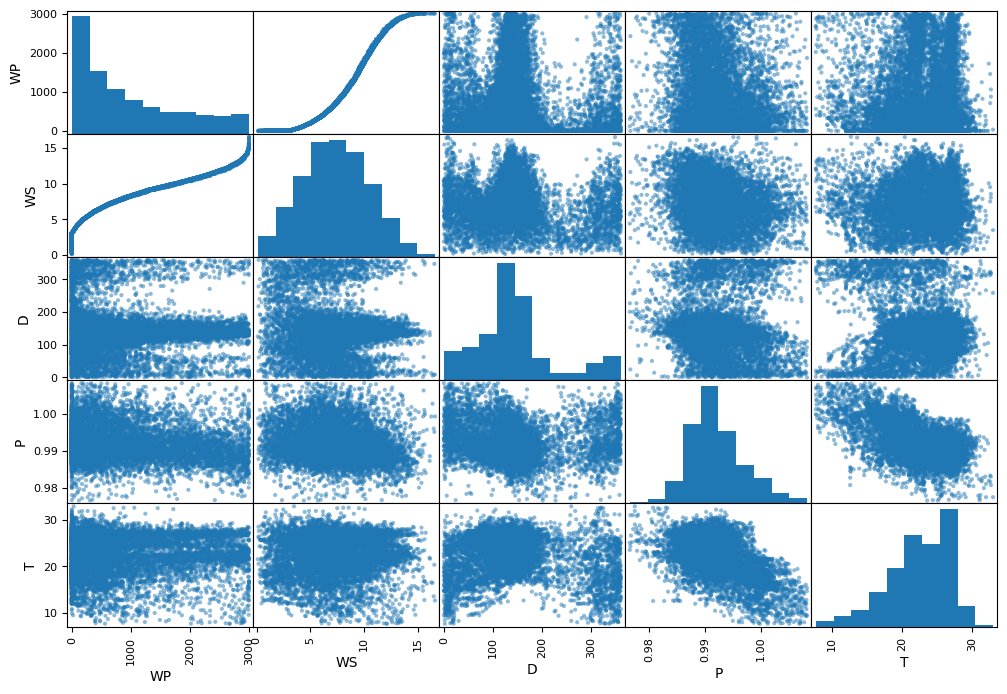

In [ ]:
attributes = list(df)

scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

In [ ]:
WP =df['WP']
WS =df['WS']
D =df['D']
P =df['P']
T =df['T']

Data visualization:

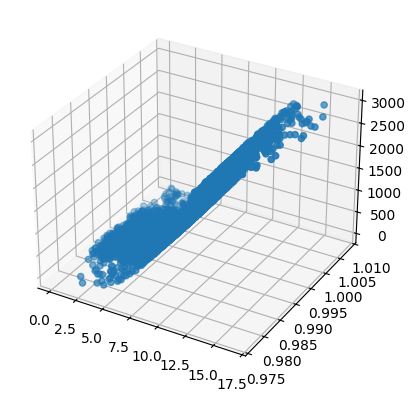

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
#plt.title('Huble parameter evolution')
ax.scatter(df['WS'], df['P'], df['WP'], label = 'parametric curve')

### 3.3 ML getting data:

In [ ]:
X = df[['WS', 'P'] ]
y = df['WP']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5999, 2), (2572, 2), (5999,), (2572,))

### 3.4 GPlearn implementation

#### 3.4.1 First test:

a) Choosing just some functions and operations decalration

In [ ]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [ ]:
function_set = ['add', 'sub', 'mul','log','cos','sin']

In [ ]:
est_gp = SymbolicRegressor(population_size=10000,function_set=function_set,
                           generations=40, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

b) Fit:

In [ ]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.89          1035.97       46          149.677          162.337     11.31m
   1    17.62           1022.4       80          104.427          114.541     11.67m
   2    29.76          3485.43       45          99.5041          118.183     12.85m
   3    38.05          33319.3       41          82.2227           71.499     14.95m
   4    51.31          14701.3       40          77.8062          65.5171     17.36m
   5    61.41          8462.28       63          70.7721          73.1053     19.30m
   6    54.82          6002.08       63          69.9043          80.9141     16.90m
   7    51.59          7254.31       63          69.3795          72.5686     16.52m
   8    49.65          10247.6       52          67.2676          67.5862  

c) Prediction

In [ ]:
t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.003530740737915039 seconds


d) Score

In [ ]:
score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

R2: 0.9994117920148726


##### 3.4.1.1. **Visualizing the symbolic function**

a) Equation

In [ ]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [ ]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

((X0**3*(X1 + 0.047) + X0*(X1 + 0.047)*log(X0) + X0*(cos(2*X1*log(X0) + 0.684560054591345) - 2*cos(-X0 + X1 + 0.287868139673943)) + X0*(-3.14655516328857 + I*pi)*cos(2*X1*log(X0) + 0.684560054591345)*cos(-X0 + X1 + sin(3.14655516328857 - I*pi)) - 3.14655516328857 + I*pi)*cos(sin(0.066*X0)) + cos(2*X1*log(X0) + 0.684560054591345))*(cos(log(sin(log(X0 - cos(X0 + X1) + 0.0253178079842899 - I*pi)))) + cos(sin(X1 - (X1 + 0.826)*log(X0))))

b) Score

In [ ]:
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

0.9994117920148726

In [ ]:
X_test.shape

(2572, 2)

c) Plot

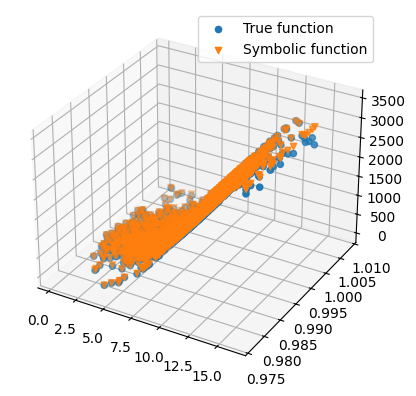

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X_test['WS'],X_test['P'],  y_test, marker='o', label = 'True function')
ax.scatter(X_test['WS'],X_test['P'],  y_gp1, marker='v',label = 'Symbolic function')
plt.legend()

Text(0.5, 0, 'WS')

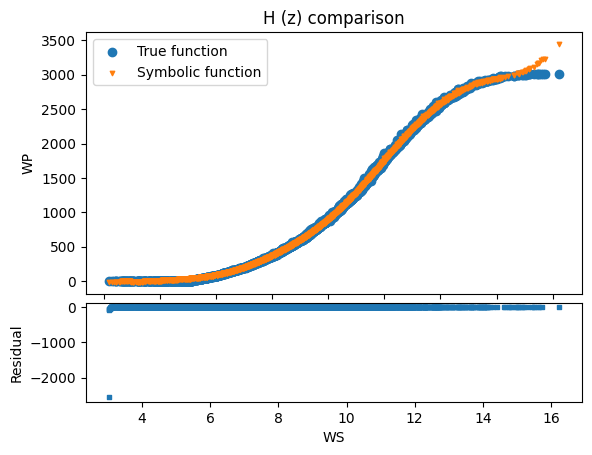

In [ ]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test['WS'], y_test, label = 'True function')
plt.scatter(X_test['WS'], y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('WP')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test['WS'], 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('WS')

d) Tree

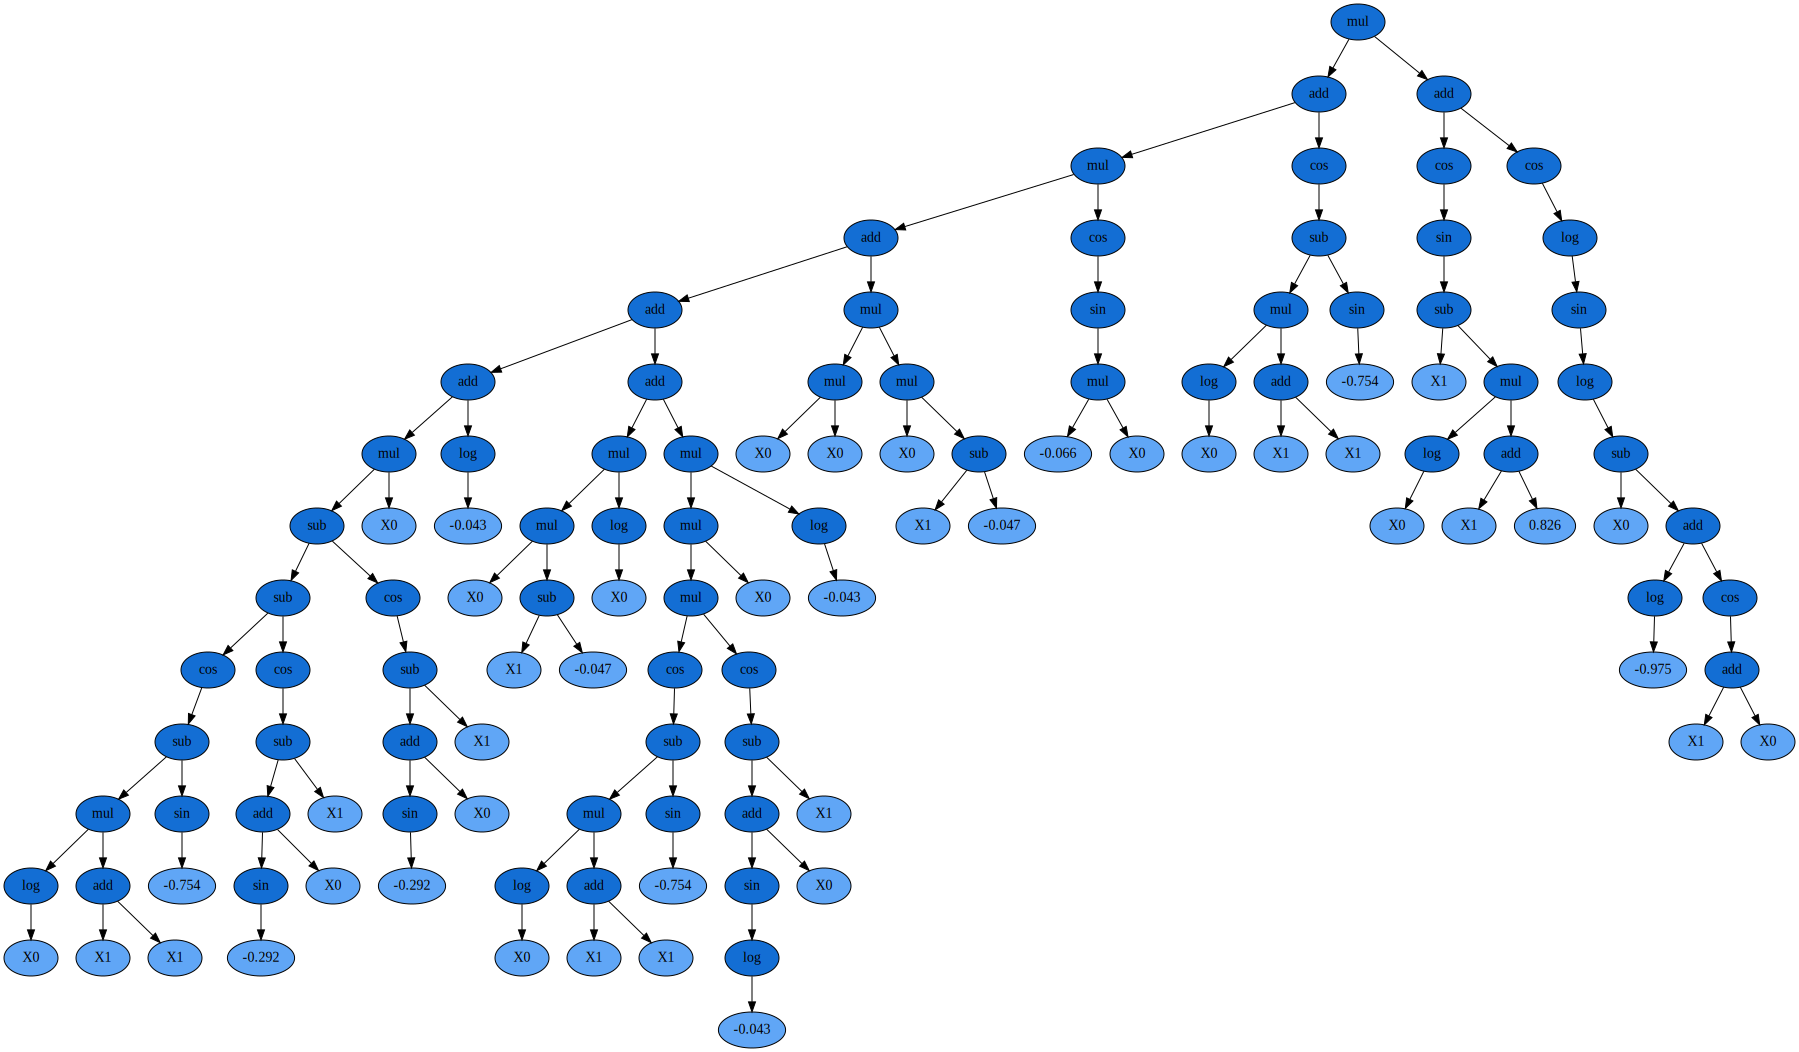

In [ ]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1', format='png', cleanup=True)
graph

#### 3.4.2 Second test:

a) Don't imposing any function

In [ ]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

b) Fit

In [ ]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c) Prediction

In [ ]:
t0 = time.time()
y_gp2 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

d) Score

In [ ]:
score_gp2 = est_gp.score(X_test, y_test)
print('R2:', score_gp2)

##### 3.4.2.1 **Visualizing the symbolic function**

a) Equation

In [ ]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

b) Plot

In [ ]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test['WS'], y_test, label = 'True function')
plt.scatter(X_test['WS'], y_gp2, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test['WS'], 1. - y_gp2/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

c) Tree

In [ ]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex2', format='png', cleanup=True)
graph

### 3.5 Comparing GPlearn to traditional ML approaches

#### 3.5.1 Decision Tree Regressor

a) Model and fit

In [ ]:
est_tree = DecisionTreeRegressor(max_depth=5)
t0 = time.time()
est_tree.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

b) Prediction and score

In [ ]:
t0 = time.time()
y_tree = est_tree.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

In [ ]:
#Score
score_tree = est_tree.score(X_test, y_test)
print('DT:', score_tree)

c) Plot

In [ ]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test['WS'], y_test, label = 'True function')
plt.scatter(X_test['WS'], y_tree, marker = 'v', s = 10, label = 'Decision Tree')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test['WS'], 1. - y_tree/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

#### 3.5.2 Random Forest Regressor

a) Model and Fit

In [ ]:
est_rf = RandomForestRegressor(n_estimators=100,max_depth=5)
t0 = time.time()
est_rf.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

b) Prediction and Score

In [ ]:
t0 = time.time()
y_rf = est_rf.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

In [ ]:
score_rf = est_rf.score(X_test, y_test)
print('RF:', score_rf)

c) Plot

In [ ]:
#Plot
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test['WS'], y_test, label = 'True function')
plt.scatter(X_test['WS'], y_rf, marker = 'v', s = 10, label = 'Random Forest')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test['WS'], 1. - y_rf/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

#### 3.5.3 All together

In [ ]:
fig = plt.figure(figsize=(12, 10))
for i, (y, score, title) in enumerate([(y_test, None, "Ground Truth"),
                                       (y_gp2, score_gp2, r"Symbolic Regressor: Score $= {:.4f}$".format(score_gp2)),
                                       (y_tree, score_tree, r"DecisionTreeRegressor: Score $= {:.4f}$".format(score_tree)),
                                       (y_rf, score_rf, r"RandomForestRegressor: $Score = {:.4f}$".format(score_rf))]):
    ax = fig.add_subplot(2, 2, i+1)
    points = ax.scatter(X, y_true, alpha=0.5)
    test = ax.scatter(X_test,y, alpha=0.5)
    plt.title(title)